In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from math import sqrt
filepath = 'C:/Users/Anthony/Dropbox/Background Understanding/Data Science/CDIPS/CDIPS15_TeamCat/'

# After TrainTest02 csv files creation

I am reading in the csv files I created in TrainTest02.ipynb for the initial construction of our model

In [2]:
train = pd.read_csv(os.path.join(filepath,"train.csv"),index_col=0)
test = pd.read_csv(os.path.join(filepath,"test.csv"),index_col=0)

How many quotes are there for a single purchase? 2575

How many tube assemblies are there? 2592

That means that not every tube assembly has a price quote for a single purchase

This just happens that 17/2592 tube assemblies don't have a price quote for a single purchase. So I'll focus just on quantity = 1

### Most quotes are for 1,2,5,10,25,50,100,250 (98%)

Most quotes are for quantity 1, so let's focus on 1 right now for exploring price and total number of parts to an assembly

Percentage of quotes that are for quantities 1,2,5,10,25,50,100,250: 0.98087603479
Axes(0.125,0.125;0.775x0.775)


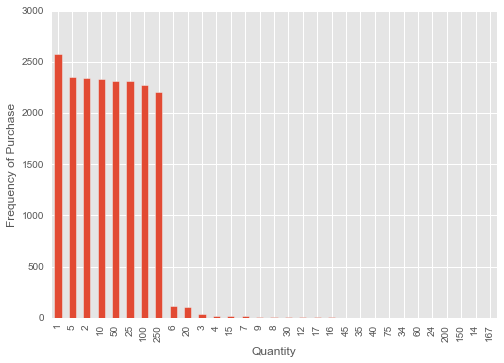

In [3]:
quant = [len(train[train['quantity']==x]) for x in range(train['quantity'].max()+1)]
quant_s = pd.Series(quant)
quant_s.names = "frequency"
quant_s.sort(ascending = False)
print 'Percentage of quotes that are for quantities 1,2,5,10,25,50,100,250:', sum(quant_s[[1,2,5,10,25,50,100,250]])/float(sum(quant_s))
print quant_s[quant_s.values != 0].plot(kind = 'bar')
plt.xlabel('Quantity')
plt.ylabel('Frequency of Purchase')
# plt.xlim((0,260))


### Just look at subset of quantity 1

Last week, Paul asked about plotting the number of parts per assembly vs. cost

In [4]:
quant_1 = train[train['quantity']==1].copy()

In [5]:
quant_1.index = range(len(quant_1))
totalQuant = [quant_1.loc[x]['quantity_1'] + quant_1.loc[x]['quantity_2'] + quant_1.loc[x]['quantity_3'] for x in quant_1.index]
quant_1.loc[:,'totalQuant'] = totalQuant

In [6]:
quant_1[['quantity_1','quantity_2','quantity_3','totalQuant']].head()

,quantity_1,quantity_2,quantity_3,totalQuant
0,2,0,0,2
1,2,0,0,2
2,1,1,1,3
3,2,0,0,2
4,2,2,0,4


Most assemblies have 2,3, or 4 parts. Not sure what 0 parts is supposed to mean. Maybe look into that in more detail later.

[ 2.  3.  4.  1.  0.  5.  8.  6.]


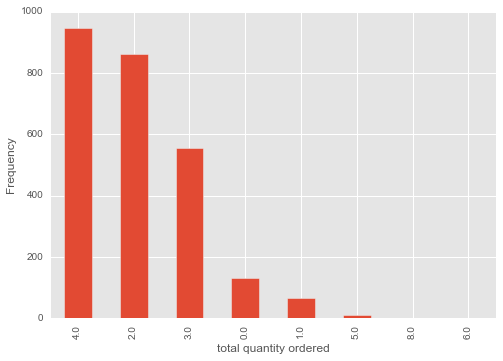

In [7]:
print quant_1['totalQuant'].unique()
quant_1['totalQuant'].value_counts().plot(kind = 'bar')
# plt.bar(train3['totalQuant'].unique(),train3['totalQuant'].value_counts())
plt.xlabel('total quantity ordered')
plt.ylabel('Frequency')

No obvious direct connection. There are other orthogonal variables influencing cost more than quantity.

(-10, 500)

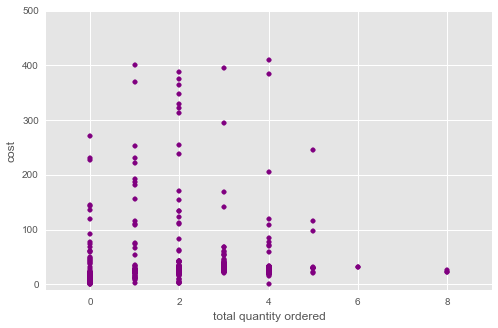

In [8]:
fig, ax = plt.subplots(figsize = (8,5))

quantityplot = quant_1[['totalQuant','cost']]
ax.scatter(quant_1['totalQuant'].values,quant_1['cost'].values, color = 'Purple')
ax.set_xlabel('total quantity ordered')
ax.set_ylabel('cost')
ax.set_ylim((-10,500))

# Look at pair plots for relevant data

In this case, I wanted to look at all the possible combinations in the data frame to see if there are any potential relationships that we can elminate in creating our basis set. Also, maybe there is one dominant variable in predicting price.

I felt that we should look at the  ['cost','quantity_1','quantity_2','quantity_3','diameter','wall','length','num_bends','bend_radius','year','month','day','totalQuant'] features



In [9]:
pairData = quant_1[['cost','quantity_1','quantity_2','quantity_3','diameter','wall','length','num_bends','bend_radius','year','month','day','totalQuant']].copy()

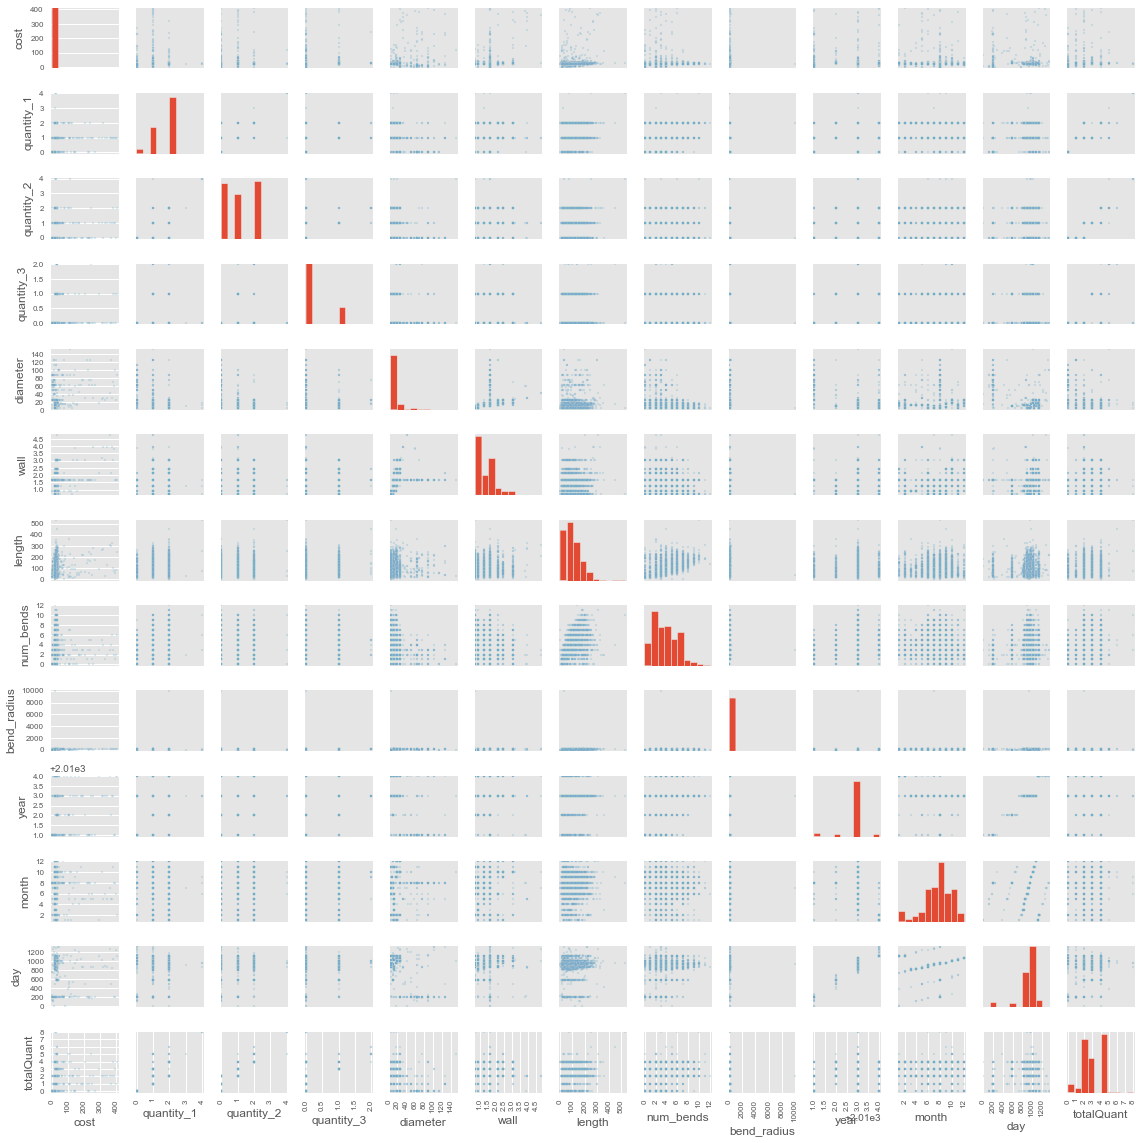

In [10]:
# fig, ax = plt.subplots(figsize = (16,16))
pd.tools.plotting.scatter_matrix(pairData, alpha=0.2, figsize = (16,16))
plt.tight_layout()
plt.savefig('scatter_matrix.png')

# Correlation maps

I also examined that correlation between different variables

First - check out Pearson correlation (linear)

Second - check out Kendall Tau correlation

Third - check out Spearman correlation

In [11]:
corr = pairData.corr()
# corr

In [12]:
mask = np.zeros_like(corr, dtype=np.bool)
# print mask

In [13]:
mask[np.triu_indices_from(mask)] = True
# np.triu_indices(mask.shape[0])
# mask

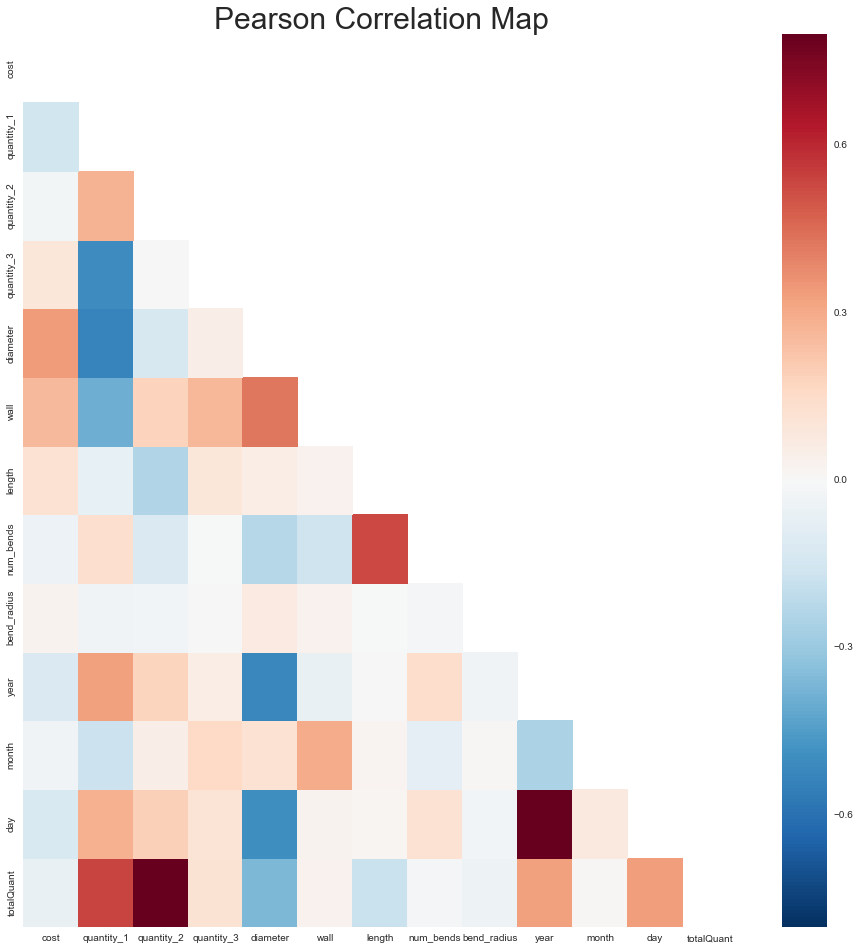

In [14]:
sns.set(style="white")
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corr, mask=mask, vmax=0.8)
plt.title('Pearson Correlation Map',fontdict = {'fontsize': 30})

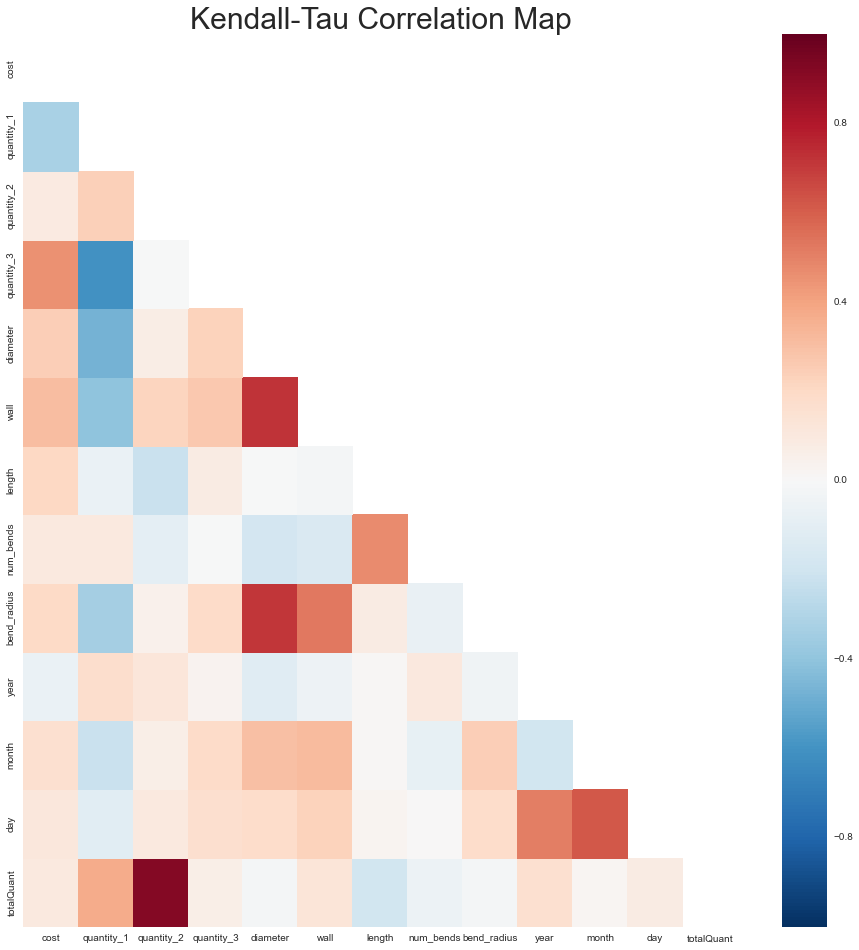

In [15]:
corrKen = pairData.corr(method = 'kendall')
sns.set(style="white")
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corrKen, mask=mask, vmax=1)
plt.title('Kendall-Tau Correlation Map',fontdict = {'fontsize': 30})

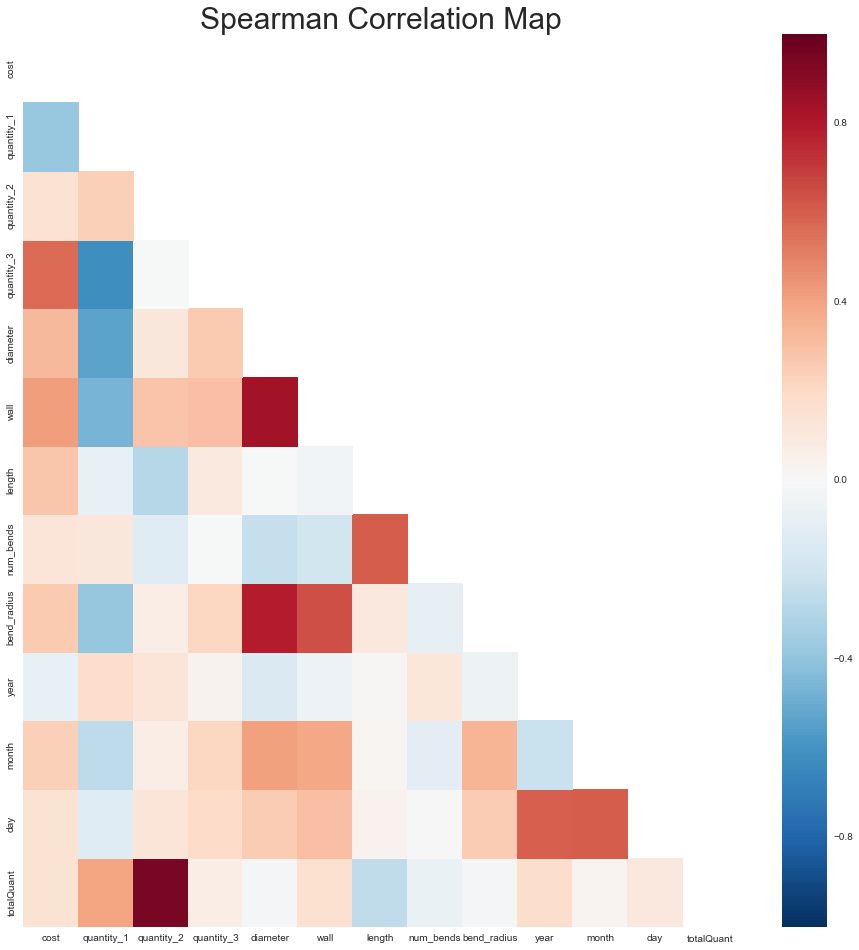

In [16]:
corrSp = pairData.corr(method = 'spearman')
sns.set(style="white")
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corrSp, mask=mask, vmax=1)
plt.title('Spearman Correlation Map',fontdict = {'fontsize': 30})

# Bracket Pricing Fit

Here, I am exploring how the cost changes with bracket pricing for each 'tube_assembly_id'. I'll start by exploring just 'TA-00002' and 'TA-00004' to get a sense of the relationship

In [17]:
ta02 = train[train['tube_assembly_id'] == 'TA-00002']
ta02_data_quant = ta02.loc[:, ['quantity']]
ta02_data_cost = ta02.loc[:, 'cost']

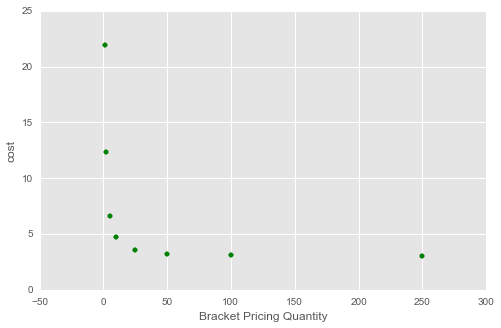

In [18]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (8,5))

ax.scatter(ta02_data_quant, ta02_data_cost, color='green')
ax.set_xlabel('Bracket Pricing Quantity')
ax.set_ylabel('cost')

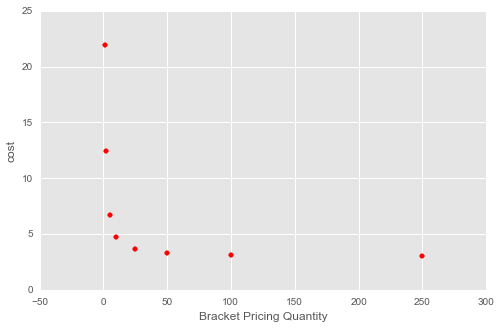

In [19]:
ta04 = train[train['tube_assembly_id'] == 'TA-00004']
ta04_data_quant = ta04.loc[:, ['quantity']]
ta04_data_cost = ta04.loc[:, 'cost']
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (8,5))

ax.scatter(ta04_data_quant, ta04_data_cost, color='red')
ax.set_xlabel('Bracket Pricing Quantity')
ax.set_ylabel('cost')

### Logistic Regression

Here, I will try fitting the Bracket Pricing to a Logistic Function. I believe it is doing this:

$$y = \frac{1}{1+e^{-t}}$$

where 

$$ t = \beta _{1}x+\beta_{0} $$

and we are solving for the beta values (coef and intercept)

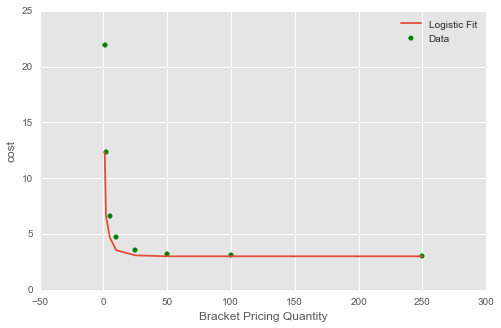

In [20]:
from sklearn.linear_model import LogisticRegression
ta02_data_quantlogit = ta02.loc[:, ['quantity']] # I need to do ['quantity'] or else python thinks the array is size 1
ta02_data_costlogit = ta02.loc[:, 'cost']
logit = LogisticRegression(fit_intercept = True)
logit.fit(ta02_data_quantlogit, ta02_data_costlogit)

fig, ax = plt.subplots(figsize = (8,5))

ax.scatter(ta02_data_quantlogit, ta02_data_costlogit, color='green', label = 'Data')
ax.plot(ta02_data_quantlogit,logit.predict(ta02_data_quantlogit), label = 'Logistic Fit')
ax.legend(loc=1)
ax.set_xlabel('Bracket Pricing Quantity')
ax.set_ylabel('cost')

### Not sure what to do with this array of coefficients

In [21]:
logit.coef_ , logit.intercept_

(array([[ 0.01014848],
        [-0.00127573],
        [-0.00854534],
        [-0.0210061 ],
        [-0.05967737],
        [-0.12876947],
        [-0.3278566 ],
        [-0.5142795 ]]),
 array([-1.44672789, -1.01822204, -0.84678843, -0.69125056, -0.46287454,
        -0.26654541,  0.02458414,  0.18799191]))

Showing what my prediction values (y-axis) and my quantity values (x-axis)

In [22]:
pred = logit.predict(ta02_data_quantlogit)
print ta02_data_quantlogit
print pred
# print logit.score(pred,train5_data_cost)

   quantity
0         1
1         2
2         5
3        10
4        25
5        50
6       100
7       250
[ 12.34121398   6.60182614   4.68776951   3.54156118   3.08252144
   2.99905966   2.99905966   2.99905966]


## Throwing out data that has too few data points for a logistic fit

The above fit on 'TA-00002' has 8 points to fit a logistic function, but some tube assemblies have 1,2,3 points - which I believe aren't enough to get a meaningful fit (8 is already very small).

I want to see how much data I'm throwing away if I only want to look at tube assembly bracket pricing with more than 2,3,4,5,6,7 data points

In [23]:
def discardAmount(num):    
    multiprice = train.copy()
    totalrows = multiprice.shape[0]
    print multiprice.shape
    for t in train['tube_assembly_id'].unique():
        if len(train[train['tube_assembly_id'] == t]) < num:
            multiprice = multiprice[multiprice['tube_assembly_id'] != t]
    print multiprice.shape
    discard = totalrows - multiprice.shape[0]
    percentdiscard = float(discard)/totalrows
    print "Percent discarded from DataFrame for less than", num, "data points:", percentdiscard

for x in [2,3,4,5,6,7,8]:
    print discardAmount(x)

(19086, 24)
(19039, 24)
Percent discarded from DataFrame for less than 2 data points: 0.00246253798596
None
(19086, 24)
(18891, 24)
Percent discarded from DataFrame for less than 3 data points: 0.0102169129205
None
(19086, 24)
(18534, 24)
Percent discarded from DataFrame for less than 4 data points: 0.0289217227287
None
(19086, 24)
(18442, 24)
Percent discarded from DataFrame for less than 5 data points: 0.0337420098502
None
(19086, 24)
(18352, 24)
Percent discarded from DataFrame for less than 6 data points: 0.0384575081211
None
(19086, 24)
(18148, 24)
Percent discarded from DataFrame for less than 7 data points: 0.0491459708687
None
(19086, 24)
(17658, 24)
Percent discarded from DataFrame for less than 8 data points: 0.0748192392329
None


The team decided that fewer than we can discard tube assembly IDs with fewer than 7 data points.

In [24]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(fit_intercept = True)

multiprice = train.copy()
for t in train['tube_assembly_id'].unique():
    if len(train[train['tube_assembly_id'] == t]) < 7:
        multiprice = multiprice[multiprice['tube_assembly_id'] != t]
dflog = pd.DataFrame()
for t in multiprice['tube_assembly_id'].unique():
    temp = multiprice[multiprice['tube_assembly_id'] == t]
    X = temp.loc[:, ['quantity']]
    y = temp.loc[:,'cost']
    logit.fit(X,y)
    tempdf = pd.DataFrame({'tube_assembly_id':[t],
                           'coef': logit.coef_[0][0],
                           'intercept': logit.intercept_[0]})
    dflog = dflog.append(tempdf)

In [25]:
print "Unique coefficients for logistic regression:", len(dflog['coef'].unique())
print "Unique intercepts for logistic regression:", len(dflog['intercept'].unique())

Unique coefficients for logistic regression: 5
Unique intercepts for logistic regression: 5


### Logistic Regression results

It looks like the majority of coefficients and intercepts for

$$ t = \beta _{1}x+\beta_{0} $$

are 

$$ \beta _{1} \approx 0.0101 $$

$$ \beta_{0} \approx -1.45 $$

 0.010148    2205
 0.020110      69
-0.547366       1
 0.022918       1
 0.009521       1
dtype: int64


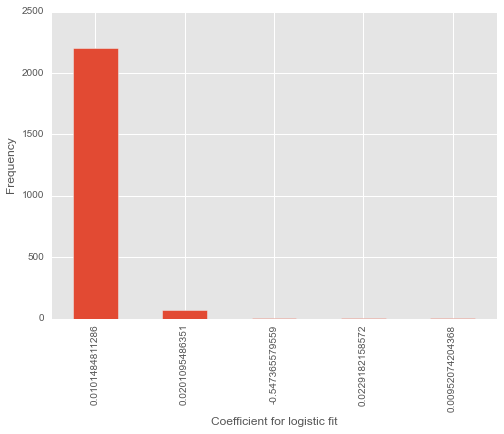

In [26]:
print dflog['coef'].value_counts()

dflog['coef'].value_counts().plot(kind= 'bar')
plt.xlabel('Coefficient for logistic fit')
plt.ylabel('Frequency')

-1.446728    2205
-1.311832      69
-1.339417       1
-1.520759       1
-0.028480       1
dtype: int64


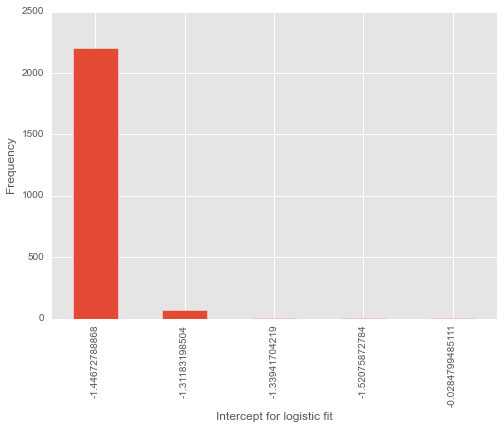

In [27]:
print dflog['intercept'].value_counts()
dflog['intercept'].value_counts().plot(kind = 'bar')
plt.xlabel('Intercept for logistic fit')
plt.ylabel('Frequency')